## Project Description for "Python for Data Science" course

Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

## Load Data

### Import packages, modules and functions:

In [1]:
import numpy as np
import pandas as pd
import random
import math 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold, cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

#### Function to optimize memory usage:

In [2]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

#### Function to remove outliers:

In [3]:
def removeOutliers(array):
    upper_quartile = np.percentile(array, 75)
    lower_quartile = np.percentile(array, 25)
    IQR = (upper_quartile - lower_quartile) * 1.5
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    print(f"Lower quartile: {quartileSet[0]}")
    print(f"Upper quartile: {quartileSet[1]}")
    countL = 0
    countU = 0
    for y in array.tolist():
        if y < quartileSet[0]:
            countL += 1
        elif y > quartileSet[1]:
            countU += 1
    array[array < quartileSet[0]] = quartileSet[0]
    array[array > quartileSet[1]] = quartileSet[1]
    print(f"Number of outliers that were updated with lower quartile: {countL}")
    print(f"Number of outliers that were updated with upper quartile: {countU}")

#### Function to evaluate prediction

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    # Evaluate the model, compare predict and true values    
    # parameters: true_values, pred_values, save    
    # no returns
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "mean(target):\t" + str(round(np.mean(true_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### Loading the dataset

#### Data description

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [5]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train_df = optimizing_df(train_df)
test_df = optimizing_df(test_df)

## Analyze data

In [8]:
train_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.93750
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.43750
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.90625


In [9]:
test_df.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B


#### Observations: 
* Ecology_2, Ecology_3 and Shops_2 are having alphabetical values
* LifeSquare, Healthcare_1 have some NaN values

In [10]:
#Verify that the number of columns in train is the same as in test
train_df.shape[1]-1 == test_df.shape[1]

True

In [11]:
train_df.dtypes

Id                 uint16
DistrictId          uint8
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor               uint8
HouseFloor        float32
HouseYear          uint32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1            uint8
Social_2           uint16
Social_3            uint8
Healthcare_1      float32
Helthcare_2         uint8
Shops_1             uint8
Shops_2          category
Price             float32
dtype: object

In [12]:
train_df.dtypes.value_counts()

float32     8
uint8       6
category    3
uint16      2
uint32      1
dtype: int64

In [13]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


#### Observations: 
* "Id" and "DistrictId" can't be used to predict the price the way they are present right now. They either have to be droped from the features or grouped/combined with other features
* "Rooms" and "KitchenSquare" have min value equal 0
* Max value for "Square": 641.065186, "LifeSquare":7480.592285 and KitchenSquare: 2014.000000 are very different
* Min value for HouseFloor is 0 

In [14]:
# Set "Id" and "DistrictId" to str to drop these features later in the project as these features can't be used to predict price
train_df["Id"] = train_df["Id"].astype(str)
train_df["DistrictId"] = train_df["DistrictId"].astype(str)

test_df["Id"] = test_df["Id"].astype(str)
test_df["DistrictId"] = test_df["DistrictId"].astype(str)

### Analyze Target: Price

In [15]:
train_df["Price"].describe()

count     10000.000000
mean     214139.218750
std       92872.304688
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

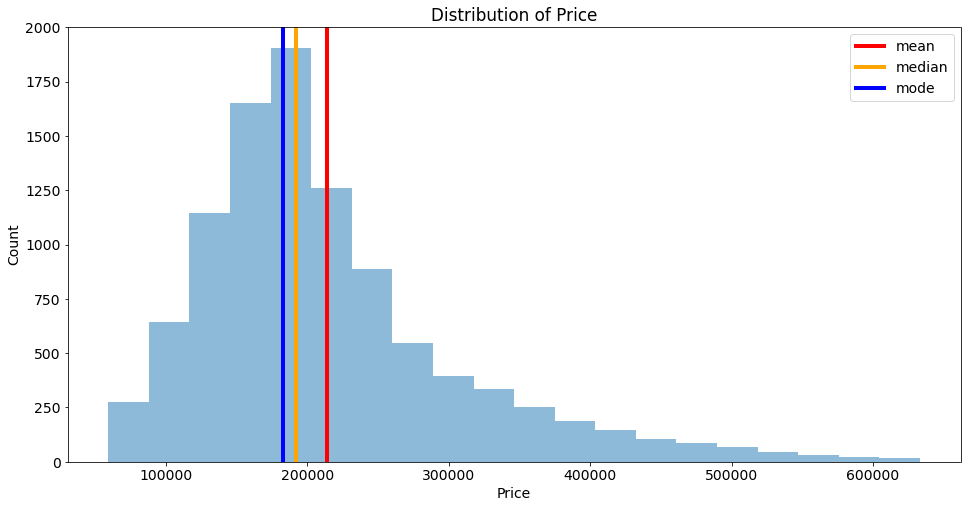

In [16]:
target_mean = round(train_df["Price"].mean(), 2)
target_median = train_df["Price"].median()
target_mode = train_df["Price"].mode()[0]

plt.figure(figsize = (16, 8))
plt.hist(train_df["Price"], bins=20, density=False, alpha=0.5)
plt.axvline(target_mean, label='mean',  linewidth=4, color="red")
plt.axvline(target_median, label='median',  linewidth=4, color="orange")
plt.axvline(target_mode, label='mode',  linewidth=4, color="blue")

plt.legend(loc='best')
plt.title('Distribution of Price')
plt.ylabel('Count')
plt.xlabel('Price')
plt.show()

#### Observations: 
* Minimum price is larger than zero. 
* Don't see any points that are significantly different from other observations / outliers

### Analyze Features

#### Features available in the dataset:

In [17]:
train_df_features = train_df.columns.values
train_df_features

array(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare',
       'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
       'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype=object)

#### Features that are numerical:

In [18]:
train_df.select_dtypes(include=["uint8","uint16", "float32", "uint32"]).columns.tolist()

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

#### Features that are categorical:

In [19]:
train_df_cat_features = train_df.select_dtypes(include=["object","category"]).columns.tolist()
train_df_cat_features

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
for cat_colname in train_df_cat_features[2:]:
    print(str(cat_colname) + "\n" + str(train_df[cat_colname].value_counts()) + "\n" + "*" * 100 + "\n")

Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



#### Features that have missing data:

In [21]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [22]:
test_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

#### Observations: 
* LifeSquare and Healthcare_1 features have missing data.

In [23]:
#Replace missing LifeSquare with (Square - KitchenSquare)
train_df.loc[train_df["LifeSquare"].isnull(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df["LifeSquare"].isnull(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

In [24]:
#Replace missing Healthcare_1 with next value
train_df.loc[train_df["Healthcare_1"].isnull(), "Healthcare_1"] = train_df["Healthcare_1"].median()
test_df.loc[test_df["Healthcare_1"].isnull(), "Healthcare_1"] = test_df["Healthcare_1"].median()

## Work with Outlier

#### Rooms

In [25]:
train_df["Rooms"].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

In [26]:
train_df.loc[train_df["Rooms"].isin([0]), "Rooms"] = 1
train_df.loc[train_df["Rooms"].isin([10,19]), "Rooms"] = 6

In [27]:
test_df["Rooms"].value_counts().sort_index()

0.0        2
1.0     1769
2.0     2030
3.0     1099
4.0       90
5.0        7
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [28]:
test_df.loc[test_df["Rooms"].isin([0]), "Rooms"] = 1
test_df.loc[test_df["Rooms"].isin([17]), "Rooms"] = 6

#### Square

In [29]:
removeOutliers(train_df['Square'])

Lower quartile: 5.5862579345703125
Upper quartile: 102.08924865722656
Number of outliers that were updated with lower quartile: 12
Number of outliers that were updated with upper quartile: 230


In [30]:
removeOutliers(test_df['Square'])

Lower quartile: 5.337880611419678
Upper quartile: 102.85347890853882
Number of outliers that were updated with lower quartile: 7
Number of outliers that were updated with upper quartile: 103


####  LifeSquare

In [31]:
removeOutliers(train_df['LifeSquare'])

Lower quartile: -10.999452114105225
Upper quartile: 86.31683588027954
Number of outliers that were updated with lower quartile: 0
Number of outliers that were updated with upper quartile: 269


In [32]:
removeOutliers(test_df['LifeSquare'])

Lower quartile: -10.58433985710144
Upper quartile: 86.56128811836243
Number of outliers that were updated with lower quartile: 0
Number of outliers that were updated with upper quartile: 110


####  KitchenSquare

In [33]:
removeOutliers(train_df['KitchenSquare'])

Lower quartile: -11.0
Upper quartile: 21.0
Number of outliers that were updated with lower quartile: 0
Number of outliers that were updated with upper quartile: 47


In [34]:
removeOutliers(test_df['KitchenSquare'])

Lower quartile: -11.0
Upper quartile: 21.0
Number of outliers that were updated with lower quartile: 0
Number of outliers that were updated with upper quartile: 19


#### Square, LifeSquare, KitchenSquare

In [35]:
mask = train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']
train_df.loc[mask, 'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare']

In [36]:
mask = test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare']
test_df.loc[mask, 'Square'] = test_df['LifeSquare'] + test_df['KitchenSquare']

#### Floor , HouseFloor

In [37]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [38]:
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.], dtype=float32)

In [39]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [40]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = 1

In [41]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=uint8)

In [42]:
train_df[train_df['Floor'] > train_df['HouseFloor']].index

Int64Index([   7,   14,   16,   21,   23,   26,   35,   39,   44,   51,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1818)

In [43]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index

In [44]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x))

In [45]:
floor_outliers = test_df[test_df['Floor'] > test_df['HouseFloor']].index

In [46]:
test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x))

#### HouseYear

In [47]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: uint32

In [48]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [49]:
test_df['HouseYear'].sort_values(ascending=False)

4389    2020
4273    2020
888     2020
3255    2020
1039    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: uint16

#### Ecology_2 , Ecology_3, Shops_2

In [50]:
train_df['Ecology_2_bin']= train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin']= train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin']= train_df['Shops_2'].replace({'A':0, 'B':1})

In [51]:
test_df['Ecology_2_bin']= train_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin']= train_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin']= train_df['Shops_2'].replace({'A':0, 'B':1})

#### MedPriceByDistrict - a new feature

In [52]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [53]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [54]:
test_df.loc[test_df["MedPriceByDistrict"].isnull(), "MedPriceByDistrict"] = test_df["MedPriceByDistrict"].median()

## Data processing

### Price correlation matrix

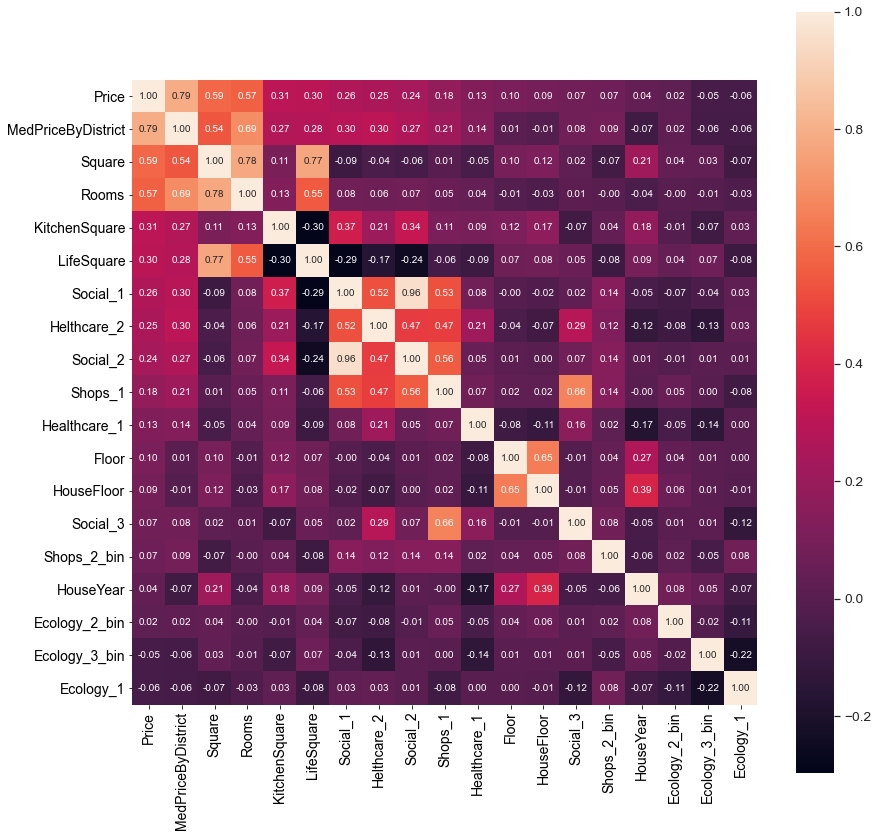

In [55]:
fig, ax = plt.subplots(figsize=(14,14))  
corrmat = train_df.corr()
k = train_df.shape[1]
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Observations: 
* MedPriceByDistrict, 'Rooms' and 'Square' have the strongest correlation with 'Price'. 
* 'Ecology_1', 'Ecology_3_bin' have a negative correlation with 'Price'

#### Filter and standardize features

In [56]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'MedPriceByDistrict']

In [57]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 
                 'HouseFloor', 'Social_1', 'Social_2', 'Social_3',
                'Healthcare_1', 'Helthcare_2', 'Shops_1',  'Shops_2_bin', 'MedPriceByDistrict']

target_name = 'Price'

In [58]:
train_df = train_df[feature_names + [target_name]]

#### Set Train and Test

In [59]:
X = train_df[feature_names]
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Best Model: Random Forest Regressor

R2:	0.782
RMSE:	43200.77
MSE:	1866306547.276
mean(target):	213872.891


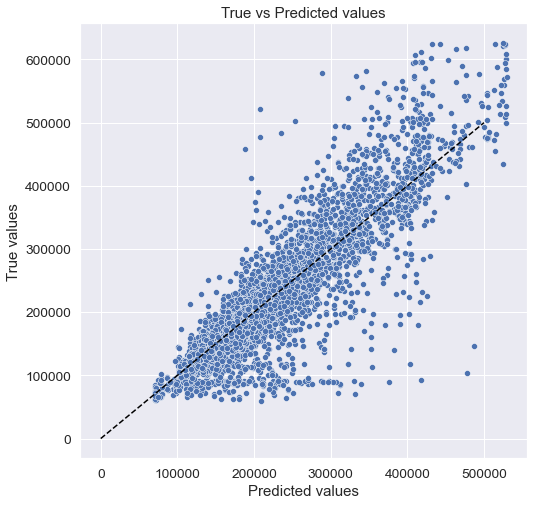

In [60]:
final_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10,  
                                 min_samples_leaf=20, 
                                 random_state=42,
                                 n_estimators=400
                                 )
final_model.fit(X_train, y_train)
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.733
RMSE:	48244.31
MSE:	2327513483.983
mean(target):	214678.344


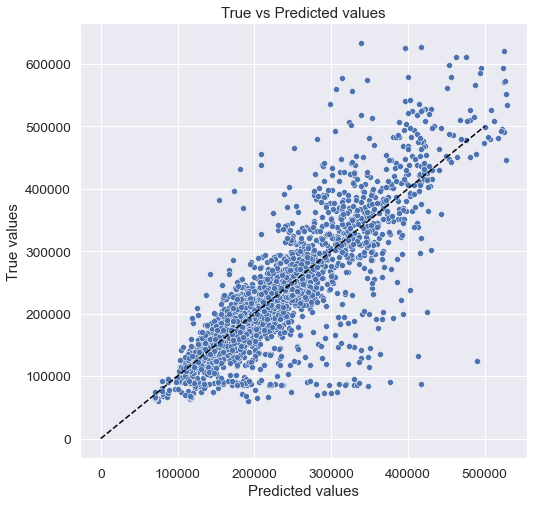

In [61]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

#### Cross Validation

In [62]:
cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
cv_score

array([0.73458561, 0.7484047 , 0.71662228, 0.76577575, 0.72353091])

In [63]:
cv_score.mean(), cv_score.std()

(0.7377838519771949, 0.017649567233804515)

In [64]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7201342847433904, 0.7554334192109994)

#### Feature importance

In [65]:
final_model.feature_importances_

array([2.39183354e-03, 1.17421741e-01, 1.47493241e-02, 2.04118778e-02,
       7.26384262e-03, 8.43435323e-03, 9.96458691e-03, 1.14690953e-02,
       2.60829913e-02, 4.23007504e-03, 1.90275353e-03, 3.61617661e-03,
       3.04421781e-04, 7.71756927e-01])

In [66]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [67]:
feature_importances

,feature_name,importance
13,MedPriceByDistrict,0.771757
1,Square,0.117422
8,Social_3,0.026083
3,KitchenSquare,0.020412
2,LifeSquare,0.014749
7,Social_2,0.011469
6,Social_1,0.009965
5,HouseFloor,0.008434
4,Floor,0.007264
9,Healthcare_1,0.004230


## Results

In [68]:
test_df['Price'] = final_model.predict(test_df[feature_names])

In [69]:
test_df[['Id', 'Price']].to_csv('AStrunova_predictions.csv', index=None)